# Noncooperative Games with Prospect Theoretic Preferences

In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [2]:
# params
n = 20
a_v = 376
b_v = 0.5
bi_v = torch.tensor(data=[1.2e3,  1.2e3, 1.499e3, 1.116e3, 1.0394e3, 
                          1.43864e3, 1.3588e3, 1.35899e3, .80848e3, 1.4185e3,
                          .7454e3, 1.079e3, 1.364466e3, 1.13779e3, 1.8925e3, 
                          1.08761e3, 2.84512e3, .988795e3, .67218e3, .928609e3], requires_grad=False, dtype=torch.float32)
y_v = torch.tensor(data=[35, 40, 32, 24, 31, 
                         44, 36, 41, 37, 29, 
                         32, 42, 50, 40, 33, 
                         37, 41, 31, 24, 30], dtype=torch.float32)
#
x_0 = torch.mean(y_v)
xi_v = torch.tensor(data=np.sort(np.random.gumbel(loc=.2, scale=0.2, size=500)), requires_grad=False, dtype=torch.float32)
P_OH_v = 15.8

The tariff is split into two parts: a fixed fee $\bar{P} > 0$ defined as a constant, during the first part of the day, and a variable charge defined during the second part of the day $P(\xi) = \bar{P} + c + \xi$ where c > 0 is a constant offset as the peak electricity price and $\xi$ is a $\mu$-mean fluctuation arbitrarily distributed over a set of $K$ atoms and such that $\xi_1 < \ldots < \xi_K$ and $p_k = P[{\xi = \xi_k}]$, $\forall k = 1, \ldots, K$.

In [3]:
# peak electricity prices
def P_PH(P_OH, xi, b=b_v):
    val = P_OH + b + xi
    return val

Moreover, to encourage the end users to take into account the social aspects of their energy consumption, the supplier imposes a penalty for deviations from a collective target. We let $y^0 = \frac{1}{N}\sum_{i=1}^{N} yi$ be the community collective target, and $\sigma(x)= \frac{1}{N}\sum_{i=1}^{N}x_i$ be the aggregate purchase. In this setting, end user i’s profit function takes the form:

$$ 
f_i(\boldsymbol{x}_i,\sigma(\boldsymbol{x}),\xi) = U_i(\sigma(\boldsymbol{x})) - C_i(\boldsymbol{x}_i,\xi)
$$

In [5]:
# U_i_C_i
def U_i_C_i(i:int, x, x_i=y_v, xi_val=xi_v[0], x0=x_0, P_OH_val=P_OH_v, b_val=b_v, y=y_v, a=a_v, b=bi_v):
    N = len(x_i)
    indices = [j for j in range(N) if j != i]
    x_neg_i = x_i[indices]
    sn = torch.sum(x_neg_i)
    a_i = a
    b_i = b[i]
    y_i = y[i]
    U_i = -a_i*((x + sn)/N - x0)**2 + b_i
    C_i = P_OH_val * x + P_PH(xi=xi_val, P_OH=P_OH_val, b=b_val) * (y_i - x)
    return U_i.item(), C_i.item()

# CVaR_simple
def CVaR_simple(ret, alpha):
    ret_arr = -np.array(ret)
    var = np.quantile(ret_arr, (1 - alpha))
    cvar_check = ret_arr[ret_arr <= var].mean()
    return cvar_check

##  EUT game

In [6]:
# obj_fun_eut
def obj_fun_eut(i, x, x_i, P_OH_val=P_OH_v, b_val=b_v, xi_val=xi_v, y=y_v, x0=x_0, a=a_v, b=bi_v):
    N = len(x_i)
    a_i = a
    b_i = b[i]
    y_i = y[i]
    mu_xi = torch.mean(xi_val)
    indices = [j for j in range(N) if j != i]
    x_neg_i = x_i[indices]
    sn = torch.sum(x_neg_i)
    U_i = - a_i * ((x + sn) / N - x0) ** 2 + b_i
    C_i = P_OH_val * x + P_PH(xi=mu_xi, P_OH=P_OH_val, b=b_val) * (y_i - x)
    res = U_i - C_i
    return res

In [7]:
# function to ensure that variables remain strictly positive
def projection(x,epsilon=1e-6):
    return torch.clamp(x, min=epsilon)

In [8]:
# optim_eut
def optim_eut(N_agents:int, y=y_v):
    # optim params
    num_iterations = 150
    tolerance = 1e-6
    learning_rate = 0.02

    x_values = np.array((num_iterations) * [np.repeat(a=np.nan, repeats=N_agents)])
    #
    for i in range(N_agents):
        x_init = torch.tensor(data=1, dtype=torch.float32)
        for iteration in range(num_iterations):
            # gradient
            x_i_copy = torch.tensor(x_init.item(), requires_grad=True)
            loss = obj_fun_eut(x=x_i_copy, x_i=y, i=i)
            loss.backward()
            # Maximiser la fonction
            x_new = x_init + learning_rate * x_i_copy.grad
            x_new = projection(x_new)
            x_values[iteration, i] = x_new.item()
            if np.abs(x_new.item() - x_init.item()) < tolerance:
                break
            x_init = x_new
    #
    res = x_values
    return res

In a non-cooperative aggregative game, each agent makes a decision based on the average of all the agents' strategies. 
We consider that each agent's only information is the consumption forecast of the others $y_i$.
The agents' decisions are made independently, in the sense that each agent chooses his or her strategy without knowing the individual choices of the others. However, these choices are influenced by aggregate information.

In [9]:
# execution EUT
all_sol_eut = optim_eut(N_agents=n)

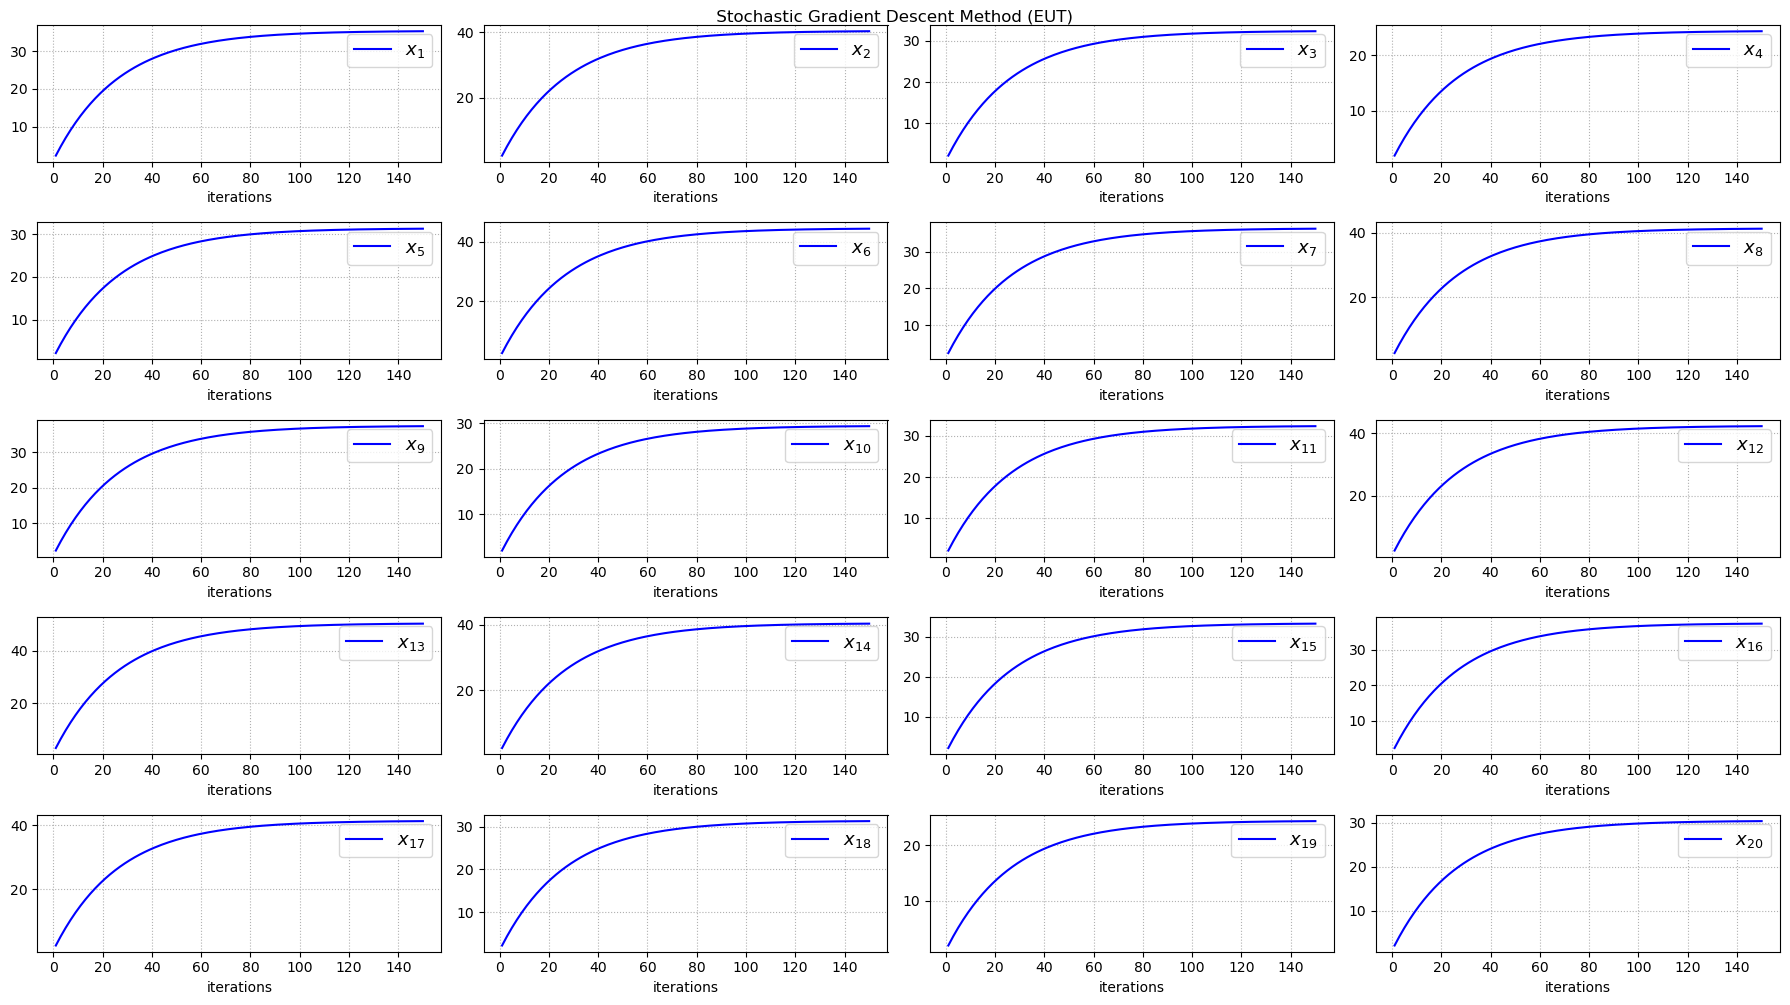

In [10]:
iterations = np.arange(len(all_sol_eut)) + 1
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8) , (ax9, ax10, ax11, ax12),
      (ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20)) = plt.subplots(nrows=5, ncols=4, figsize=(18, 10))
#------------------------------------------------------------#
ax1.plot(iterations, all_sol_eut[:, 0], color='blue', label=r'$x_1$')
ax1.legend(loc=0, fontsize=13)
ax1.grid(linestyle=':', linewidth=0.8)
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel('iterations')
#
ax2.plot(iterations, all_sol_eut[:, 1], color='blue', label=r'$x_2$')
ax2.legend(loc=0, fontsize=13)
ax2.grid(linestyle=':', linewidth=0.8)
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel('iterations')
#
ax3.plot(iterations, all_sol_eut[:, 2], color='blue', label=r'$x_3$')
ax3.legend(loc=0, fontsize=13)
ax3.xaxis.get_major_locator().set_params(integer=True)
ax3.grid(linestyle=':', linewidth=0.8)
ax3.set_xlabel('iterations')
#
ax4.plot(iterations, all_sol_eut[:, 3], color='blue', label=r'$x_4$')
ax4.legend(loc=0, fontsize=13)
ax4.grid(linestyle=':', linewidth=0.8)
ax4.xaxis.get_major_locator().set_params(integer=True)
ax4.set_xlabel('iterations')
#------------------------------------------------------------#
ax5.plot(iterations, all_sol_eut[:, 4], color='blue', label=r'$x_5$')
ax5.legend(loc=0, fontsize=13)
ax5.grid(linestyle=':', linewidth=0.8)
ax6.xaxis.get_major_locator().set_params(integer=True)
ax5.set_xlabel('iterations')
#
ax6.plot(iterations, all_sol_eut[:, 5], color='blue', label=r'$x_6$')
ax6.legend(loc=0, fontsize=13)
ax6.grid(linestyle=':', linewidth=0.8)
ax6.xaxis.get_major_locator().set_params(integer=True)
ax6.set_xlabel('iterations')
#
ax7.plot(iterations, all_sol_eut[:, 6], color='blue', label=r'$x_7$')
ax7.legend(loc=0, fontsize=13)
ax7.xaxis.get_major_locator().set_params(integer=True)
ax7.grid(linestyle=':', linewidth=0.8)
ax7.set_xlabel('iterations')
#
ax8.plot(iterations, all_sol_eut[:, 7], color='blue', label=r'$x_8$')
ax8.legend(loc=0, fontsize=13)
ax8.grid(linestyle=':', linewidth=0.8)
ax8.xaxis.get_major_locator().set_params(integer=True)
ax8.set_xlabel('iterations')
#------------------------------------------------------------#
ax9.plot(iterations, all_sol_eut[:, 8], color='blue', label=r'$x_9$')
ax9.legend(loc=0, fontsize=13)
ax9.grid(linestyle=':', linewidth=0.8)
ax9.xaxis.get_major_locator().set_params(integer=True)
ax9.set_xlabel('iterations')
#
ax10.plot(iterations, all_sol_eut[:, 9], color='blue', label=r'$x_{10}$')
ax10.legend(loc=0, fontsize=13)
ax10.grid(linestyle=':', linewidth=0.8)
ax10.xaxis.get_major_locator().set_params(integer=True)
ax10.set_xlabel('iterations')
#
ax11.plot(iterations, all_sol_eut[:, 10], color='blue', label=r'$x_{11}$')
ax11.legend(loc=0, fontsize=13)
ax11.xaxis.get_major_locator().set_params(integer=True)
ax11.grid(linestyle=':', linewidth=0.8)
ax11.set_xlabel('iterations')
#
ax12.plot(iterations, all_sol_eut[:, 11], color='blue', label=r'$x_{12}$')
ax12.legend(loc=0, fontsize=13)
ax12.grid(linestyle=':', linewidth=0.8)
ax12.xaxis.get_major_locator().set_params(integer=True)
ax12.set_xlabel('iterations')
#------------------------------------------------------------#
ax13.plot(iterations, all_sol_eut[:, 12], color='blue', label=r'$x_{13}$')
ax13.legend(loc=0, fontsize=13)
ax13.grid(linestyle=':', linewidth=0.8)
ax13.xaxis.get_major_locator().set_params(integer=True)
ax13.set_xlabel('iterations')
#
ax14.plot(iterations, all_sol_eut[:, 13], color='blue', label=r'$x_{14}$')
ax14.legend(loc=0, fontsize=13)
ax14.grid(linestyle=':', linewidth=0.8)
ax14.xaxis.get_major_locator().set_params(integer=True)
ax14.set_xlabel('iterations')
#
ax15.plot(iterations, all_sol_eut[:, 14], color='blue', label=r'$x_{15}$')
ax15.legend(loc=0, fontsize=13)
ax15.xaxis.get_major_locator().set_params(integer=True)
ax15.grid(linestyle=':', linewidth=0.8)
ax15.set_xlabel('iterations')
#
ax16.plot(iterations, all_sol_eut[:, 15], color='blue', label=r'$x_{16}$')
ax16.legend(loc=0, fontsize=13)
ax16.grid(linestyle=':', linewidth=0.8)
ax16.xaxis.get_major_locator().set_params(integer=True)
ax16.set_xlabel('iterations')
#------------------------------------------------------------#
ax17.plot(iterations, all_sol_eut[:, 16], color='blue', label=r'$x_{17}$')
ax17.legend(loc=0, fontsize=13)
ax17.grid(linestyle=':', linewidth=0.8)
ax17.xaxis.get_major_locator().set_params(integer=True)
ax17.set_xlabel('iterations')
#
ax18.plot(iterations, all_sol_eut[:, 17], color='blue', label=r'$x_{18}$')
ax18.legend(loc=0, fontsize=13)
ax18.grid(linestyle=':', linewidth=0.8)
ax18.xaxis.get_major_locator().set_params(integer=True)
ax18.set_xlabel('iterations')
#
ax19.plot(iterations, all_sol_eut[:, 18], color='blue', label=r'$x_{19}$')
ax19.legend(loc=0, fontsize=13)
ax19.xaxis.get_major_locator().set_params(integer=True)
ax19.grid(linestyle=':', linewidth=0.8)
ax19.set_xlabel('iterations')
#
ax20.plot(iterations, all_sol_eut[:, 19], color='blue', label=r'$x_{20}$')
ax20.legend(loc=0, fontsize=13)
ax20.grid(linestyle=':', linewidth=0.8)
ax20.xaxis.get_major_locator().set_params(integer=True)
ax20.set_xlabel('iterations')
#------------------------------------------------------------#
plt.tight_layout()
fig.suptitle(' Stochastic Gradient Descent Method (EUT) ', y=1.0)
plt.show()

In [11]:
# Solution EUT
sol_eut = torch.tensor(all_sol_eut[-1])

## PT game

In [12]:
# prelec prob
def prelec_prob(p:float, g:float, beta=1):
    return np.exp(-beta * (-np.log(p))**g)

p_val = np.sort(np.random.uniform(low=0.5, high=0.95, size=500))
kappa_val = [1.8, 1.8, 2.5, 2.5, 3.1, 3.1, 3.1, 1.8, 2.5, 2.5, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7,3.7]
gamma_1 = 0.7
beta_1= 1
w_p1_val = prelec_prob(p=p_val, g=gamma_1, beta=beta_1)

$$ 
\tilde{f}_i(\boldsymbol{x}_i, \sigma(\boldsymbol{x}), \xi) = \sum_{k=1}^{K} \omega_1(p_k)\log(1 + f_i(\boldsymbol{x}_i, \sigma(\boldsymbol{x}), \xi_k) - \kappa \omega_1(p_k)\log(1 - f_i(\boldsymbol{x}_i, \sigma(\boldsymbol{x}), \xi_k)
$$

In [14]:
# objective_function CPT
def obj_fun_cpt(i:int, x, x_i, w1=w_p1_val, kappa=kappa_val, P_OH_val=P_OH_v, b_val=b_v, xi_val=xi_v, y=y_v, x0=x_0, a=a_v, b=bi_v):
    # params
    kappa_v = kappa[i]
    w2 = 1 - w1
    #----------------#
    N = len(x_i)
    a_i = a
    b_i = b[i]
    y_i = y[i]
    mu_xi = torch.mean(xi_val)
    indices = [j for j in range(N) if j != i]
    x_neg_i = x_i[indices]
    sn = torch.sum(x_neg_i)
    U_i = - a_i * ((x + sn) / N - x0) ** 2 + b_i
    C_i = P_OH_val * x + P_PH(xi=mu_xi, P_OH=P_OH_val, b=b_val) * (y_i - x)
    f_i = U_i - C_i
    #----------------#
    obj = torch.tensor(w1, dtype=torch.float32) * torch.log(torch.where(f_i > 0, f_i, 0) + 1) - kappa_v * torch.tensor(w2, dtype=torch.float32) * torch.log( 1 + torch.where(f_i < 0, -f_i, 0) )
    res = torch.sum(obj)
    return res

# optim_cpt
def optim_cpt(N_agents:int, y=y_v):
    # optim params
    num_iterations = 350
    tolerance = 1e-6
    learning_rate_0 = 10e-2

    x_values = np.array((num_iterations) * [np.repeat(a=np.nan, repeats=N_agents)])
    #
    for i in range(N_agents):
        x_init = torch.tensor(data=1., dtype=torch.float32)
        for iteration in range(num_iterations):
            learning_rate = learning_rate_0 / (iteration + 1)
            # gradient
            x_i_copy = torch.tensor(x_init.item(), requires_grad=True)
            loss = obj_fun_cpt(x=x_i_copy, x_i=y, i=i)
            loss.backward()
            # Maximiser la fonction
            x_new = x_init + learning_rate * x_i_copy.grad
            x_new = projection(x_new)
            x_values[iteration, i] = x_new.item()
            if np.abs(x_new.item() - x_init.item()) < tolerance:
                break
            x_init = x_new
    #
    res = x_values
    return res

In [15]:
# execution CPT
all_sol_cpt = optim_cpt(N_agents=n)

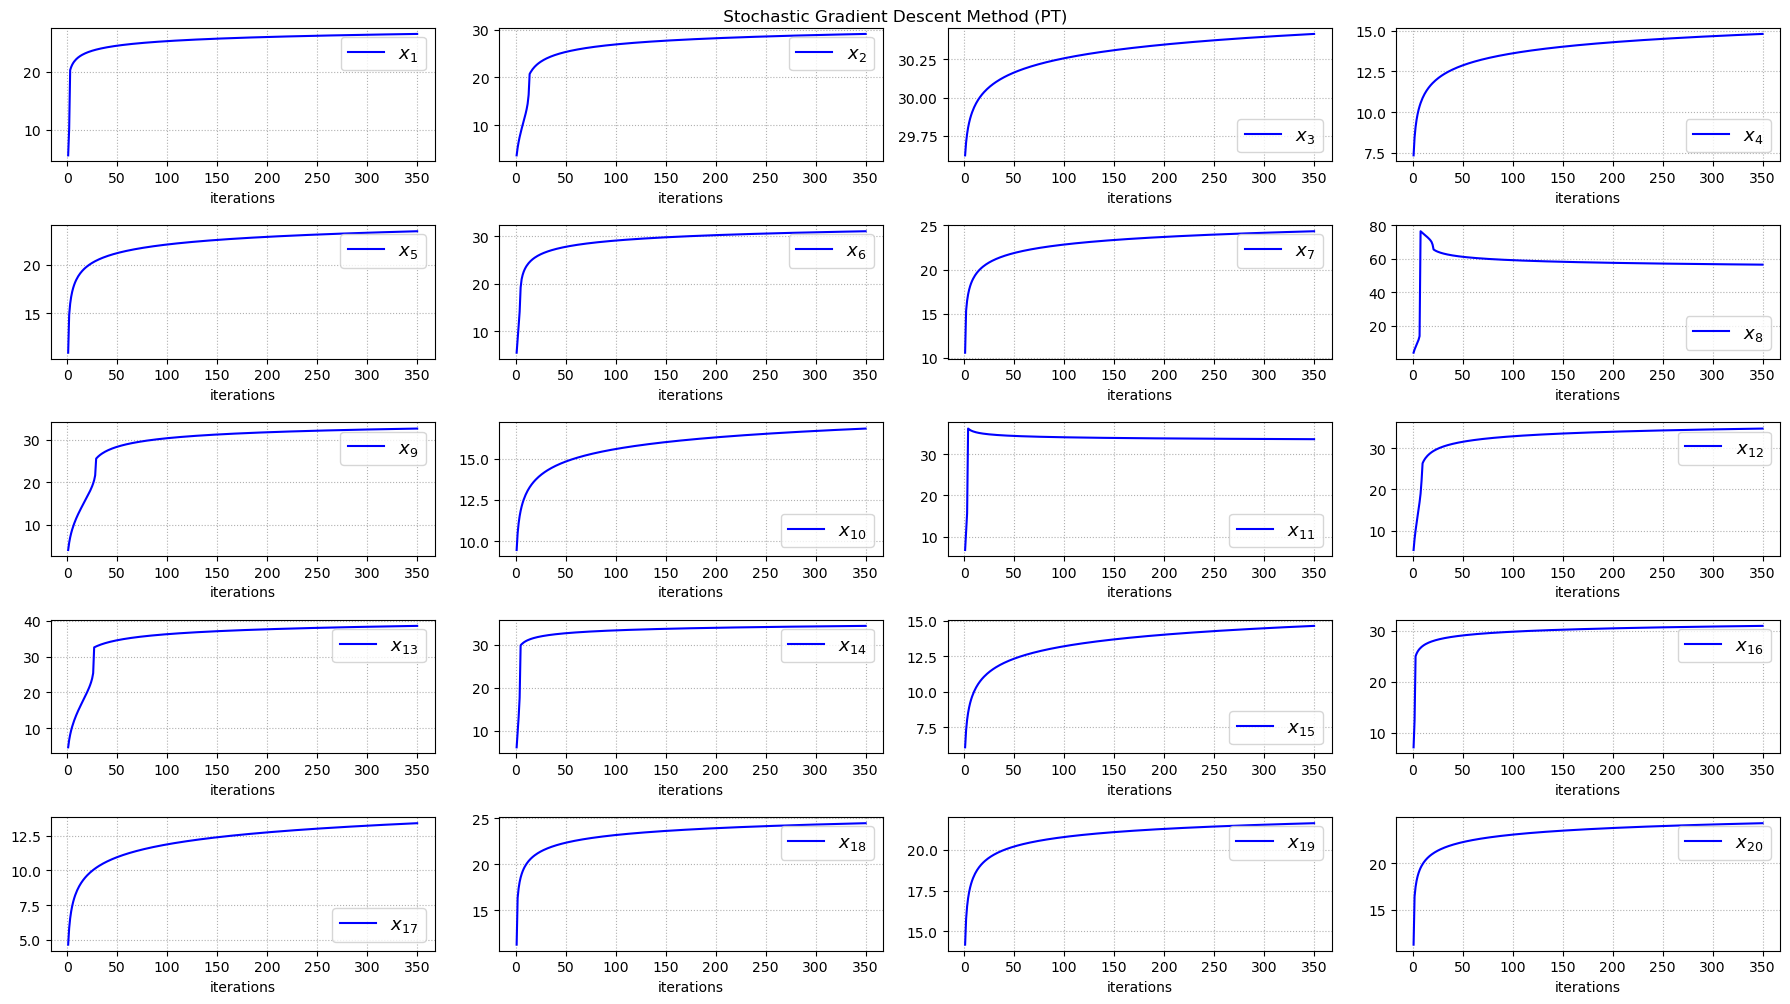

In [16]:
iterations = np.arange(len(all_sol_cpt)) + 1
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8) , (ax9, ax10, ax11, ax12),
      (ax13, ax14, ax15, ax16), (ax17, ax18, ax19, ax20)) = plt.subplots(nrows=5, ncols=4, figsize=(18, 10))
#------------------------------------------------------------#
ax1.plot(iterations, all_sol_cpt[:, 0], color='blue', label=r'$x_1$')
ax1.legend(loc=0, fontsize=13)
ax1.grid(linestyle=':', linewidth=0.8)
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel('iterations')
#
ax2.plot(iterations, all_sol_cpt[:, 1], color='blue', label=r'$x_2$')
ax2.legend(loc=0, fontsize=13)
ax2.grid(linestyle=':', linewidth=0.8)
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel('iterations')
#
ax3.plot(iterations, all_sol_cpt[:, 2], color='blue', label=r'$x_3$')
ax3.legend(loc=0, fontsize=13)
ax3.xaxis.get_major_locator().set_params(integer=True)
ax3.grid(linestyle=':', linewidth=0.8)
ax3.set_xlabel('iterations')
#
ax4.plot(iterations, all_sol_cpt[:, 3], color='blue', label=r'$x_4$')
ax4.legend(loc=0, fontsize=13)
ax4.grid(linestyle=':', linewidth=0.8)
ax4.xaxis.get_major_locator().set_params(integer=True)
ax4.set_xlabel('iterations')
#------------------------------------------------------------#
ax5.plot(iterations, all_sol_cpt[:, 4], color='blue', label=r'$x_5$')
ax5.legend(loc=0, fontsize=13)
ax5.grid(linestyle=':', linewidth=0.8)
ax6.xaxis.get_major_locator().set_params(integer=True)
ax5.set_xlabel('iterations')
#
ax6.plot(iterations, all_sol_cpt[:, 5], color='blue', label=r'$x_6$')
ax6.legend(loc=0, fontsize=13)
ax6.grid(linestyle=':', linewidth=0.8)
ax6.xaxis.get_major_locator().set_params(integer=True)
ax6.set_xlabel('iterations')
#
ax7.plot(iterations, all_sol_cpt[:, 6], color='blue', label=r'$x_7$')
ax7.legend(loc=0, fontsize=13)
ax7.xaxis.get_major_locator().set_params(integer=True)
ax7.grid(linestyle=':', linewidth=0.8)
ax7.set_xlabel('iterations')
#
ax8.plot(iterations, all_sol_cpt[:, 7], color='blue', label=r'$x_8$')
ax8.legend(loc=0, fontsize=13)
ax8.grid(linestyle=':', linewidth=0.8)
ax8.xaxis.get_major_locator().set_params(integer=True)
ax8.set_xlabel('iterations')
#------------------------------------------------------------#
ax9.plot(iterations, all_sol_cpt[:, 8], color='blue', label=r'$x_9$')
ax9.legend(loc=0, fontsize=13)
ax9.grid(linestyle=':', linewidth=0.8)
ax9.xaxis.get_major_locator().set_params(integer=True)
ax9.set_xlabel('iterations')
#
ax10.plot(iterations, all_sol_cpt[:, 9], color='blue', label=r'$x_{10}$')
ax10.legend(loc=0, fontsize=13)
ax10.grid(linestyle=':', linewidth=0.8)
ax10.xaxis.get_major_locator().set_params(integer=True)
ax10.set_xlabel('iterations')
#
ax11.plot(iterations, all_sol_cpt[:, 10], color='blue', label=r'$x_{11}$')
ax11.legend(loc=0, fontsize=13)
ax11.xaxis.get_major_locator().set_params(integer=True)
ax11.grid(linestyle=':', linewidth=0.8)
ax11.set_xlabel('iterations')
#
ax12.plot(iterations, all_sol_cpt[:, 11], color='blue', label=r'$x_{12}$')
ax12.legend(loc=0, fontsize=13)
ax12.grid(linestyle=':', linewidth=0.8)
ax12.xaxis.get_major_locator().set_params(integer=True)
ax12.set_xlabel('iterations')
#------------------------------------------------------------#
ax13.plot(iterations, all_sol_cpt[:, 12], color='blue', label=r'$x_{13}$')
ax13.legend(loc=0, fontsize=13)
ax13.grid(linestyle=':', linewidth=0.8)
ax13.xaxis.get_major_locator().set_params(integer=True)
ax13.set_xlabel('iterations')
#
ax14.plot(iterations, all_sol_cpt[:, 13], color='blue', label=r'$x_{14}$')
ax14.legend(loc=0, fontsize=13)
ax14.grid(linestyle=':', linewidth=0.8)
ax14.xaxis.get_major_locator().set_params(integer=True)
ax14.set_xlabel('iterations')
#
ax15.plot(iterations, all_sol_cpt[:, 14], color='blue', label=r'$x_{15}$')
ax15.legend(loc=0, fontsize=13)
ax15.xaxis.get_major_locator().set_params(integer=True)
ax15.grid(linestyle=':', linewidth=0.8)
ax15.set_xlabel('iterations')
#
ax16.plot(iterations, all_sol_cpt[:, 15], color='blue', label=r'$x_{16}$')
ax16.legend(loc=0, fontsize=13)
ax16.grid(linestyle=':', linewidth=0.8)
ax16.xaxis.get_major_locator().set_params(integer=True)
ax16.set_xlabel('iterations')
#------------------------------------------------------------#
ax17.plot(iterations, all_sol_cpt[:, 16], color='blue', label=r'$x_{17}$')
ax17.legend(loc=0, fontsize=13)
ax17.grid(linestyle=':', linewidth=0.8)
ax17.xaxis.get_major_locator().set_params(integer=True)
ax17.set_xlabel('iterations')
#
ax18.plot(iterations, all_sol_cpt[:, 17], color='blue', label=r'$x_{18}$')
ax18.legend(loc=0, fontsize=13)
ax18.grid(linestyle=':', linewidth=0.8)
ax18.xaxis.get_major_locator().set_params(integer=True)
ax18.set_xlabel('iterations')
#
ax19.plot(iterations, all_sol_cpt[:, 18], color='blue', label=r'$x_{19}$')
ax19.legend(loc=0, fontsize=13)
ax19.xaxis.get_major_locator().set_params(integer=True)
ax19.grid(linestyle=':', linewidth=0.8)
ax19.set_xlabel('iterations')
#
ax20.plot(iterations, all_sol_cpt[:, 19], color='blue', label=r'$x_{20}$')
ax20.legend(loc=0, fontsize=13)
ax20.grid(linestyle=':', linewidth=0.8)
ax20.xaxis.get_major_locator().set_params(integer=True)
ax20.set_xlabel('iterations')
#------------------------------------------------------------#
plt.tight_layout()
fig.suptitle(' Stochastic Gradient Descent Method (PT) ', y=1.0)
plt.show()

In [18]:
# Solution PT
sol_cpt = torch.tensor(all_sol_cpt[-1])

In [19]:
# fi_eut
fi_eut = [obj_fun_eut(i=i, x=sol_eut[i] ,x_i=y_v, xi_val=xi_v).item() for i in range(n)]
# fi_cpt
fi_cpt = [obj_fun_eut(i=i, x=sol_cpt[i] ,x_i=y_v, xi_val=xi_v).item() for i in range(n)]

# CVaR
cvar_eut = [CVaR_simple(ret=fi_eut, alpha=a) for a in np.arange(0.1, .99, 0.1)]
cvar_cpt =[CVaR_simple(ret=fi_cpt, alpha=a) for a in np.arange(0.1, .99, 0.1)]

In [20]:
# POI
POI = np.array(cvar_cpt)/np.array(cvar_eut)
POI = np.round(np.append((np.sum(fi_cpt)/np.sum(fi_eut)), POI), decimals=2)

In [22]:
POI_data = {'0.1':POI[0], '0.2':POI[1], '0.3':POI[2], '0.4':POI[3], '0.5':POI[4],
            '0.6':POI[5], '0.7':POI[6], '0.8':POI[7], '0.9':POI[8]}

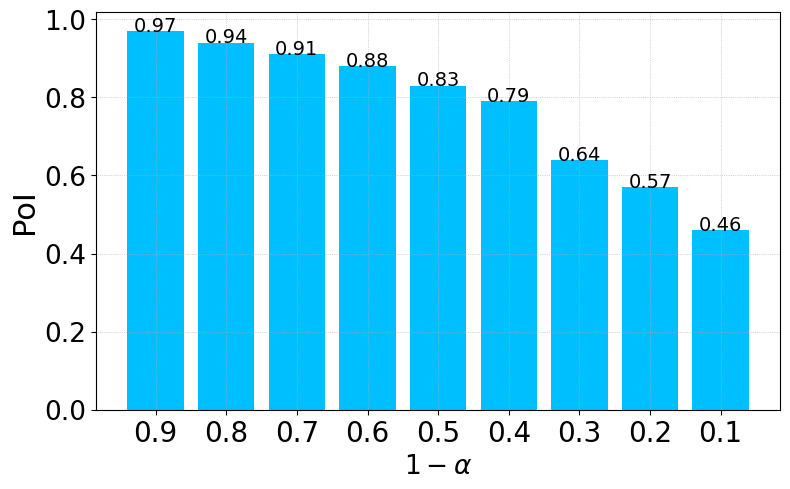

In [23]:
risk_alpha = list(POI_data.keys())
poi_values = list(POI_data.values())
alpha_val = list([f'{float(POI[i]):.2f}' for i in range(len(POI))])
# figure
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
bars = ax2.bar(risk_alpha[::-1], poi_values, color='deepskyblue')
ax2.set_xlabel(r'$1-\alpha$', fontsize=19)
ax2.set_ylabel('PoI', fontsize=22)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=19)
#ax2.legend(loc=0, fontsize=21)
ax2.grid(linestyle=':', linewidth=0.5)
for i in range(len(risk_alpha)):
    plt.text(i, (POI[i]), POI[i], ha = 'center', fontdict=dict(fontsize=14))
fig.tight_layout()


In [25]:
#--------------------------------------------------------------------------------#
# UC_eut UC_cpt
UC_eut = np.array([U_i_C_i(i=i_v, x=sol_eut[i_v]) for i_v in range(len(sol_eut))])
UC_cpt = np.array([U_i_C_i(i=i_v, x=sol_cpt[i_v]) for i_v in range(len(sol_cpt))])
#--------------------------------------------------------------------------------#
# 0%
d_0 = UC_eut
# np.sum(d_0[:,0])
# np.sum(d_0[:,1])

# 10%
d_10 = UC_eut
d_10[18:19,:] = UC_cpt[0:1,:]
# np.sum(d_10[:,0])
# np.sum(d_10[:,1])

# 25%
d_25 = UC_eut
d_25[15:19,:] = UC_cpt[0:4,:]

# 50%
d_50 = UC_eut
d_50[10:19,:] = UC_cpt[0:9,:]

# 75%
d_75 = UC_eut
d_75[5:19,:] = UC_cpt[0:14,:]

# 90%
d_90 = UC_eut
d_90[2:19,:] = UC_cpt[0:17,:]

# 100%
d_100 = UC_cpt

Ui_data = {'0%':np.sum(d_0[:,0]), '10%':np.sum(d_10[:,0]), '25%':np.sum(d_25[:,0]), '50%':np.sum(d_50[:,0]),
           '75%':np.sum(d_75[:,0]),'90%':np.sum(d_90[:,0]), '100': np.sum(d_100[:,0])}
Ci_data = {'0%':np.sum(d_0[:,1]), '10%':np.sum(d_10[:,1]), '25%':np.sum(d_25[:,1]), '50%':np.sum(d_50[:,1]),
           '75%':np.sum(d_75[:,1]),'90%':np.sum(d_90[:,1]), '100': np.sum(d_100[:,1])}

In [27]:
n_val = list(['0%', '10%', '25%', '50%', '75%','90%', '100%'])

In [28]:
ui_values = list(Ui_data.values())
ci_values = list(Ci_data.values())

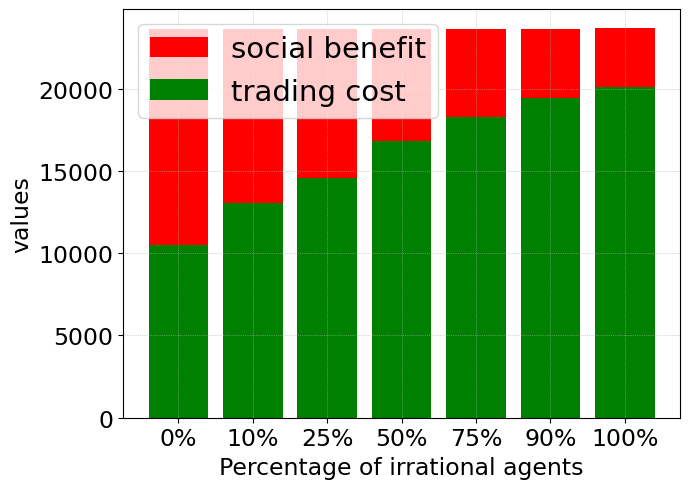

In [29]:
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
bar1 = ax2.bar(n_val, ui_values, color='r', label='social benefit')
bar2 = ax2.bar(n_val, ci_values, color='g', label='trading cost')
# ax2.legend(handles=[bar1, bar2], loc='center left', fontsize=21)
ax2.legend(handles=[bar1, bar2], loc=0, fontsize=21)
ax2.set_ylabel('values', fontsize=17)
ax2.set_xlabel('Percentage of irrational agents', fontsize=17)
ax2.tick_params(axis='x', labelsize=17)
ax2.tick_params(axis='y', labelsize=17)
#ax2.legend(loc=0, fontsize=21)
ax2.grid(linestyle=':', linewidth=0.5)
fig.tight_layout()

In [31]:
xi_val = []
for l in np.arange(0, 14, 1) :
    xi_val.append(torch.tensor(data=np.sort(np.random.gumbel(loc=l, scale=0.2, size=500)), dtype=torch.float32))
# xi_values = xi_val
#--------------------------------------------------------------------------------#
def aggregative_game(a_i, b_i, kappa_1, y_i, kappa_2, kappa_3,
                     beta_v=1, gamma_v=0.5, N=3, xi_values=xi_val,
                     P_bar=15.8, b_val=0.5):
    a_v = torch.tensor(data=a_i, dtype=torch.float32)
    b_v = torch.tensor(data=[b_i, b_i, b_i], dtype=torch.float32)
    kappa_val = torch.tensor(data=[kappa_1, kappa_2, kappa_3], dtype=torch.float32)
    p_val = np.sort(np.random.uniform(low=0.5, high=0.98, size=500))
    w_1 = prelec_prob(g=gamma_v, beta=beta_v,p=p_val)
    y_va = torch.tensor(data=[y_i, y_i, y_i], dtype=torch.float32)
    x0_v = torch.mean(y_va)
    #
    # extract_sol
    def extract_sol(data):
        sol = []
        N = data.shape[1]
        for i in range(N):
            x1 = data[:, i]
            x1 = x1[~np.isnan(x1)]
            sol.append(x1[-1])
        res = torch.tensor(np.array(sol), dtype=torch.float32)
        return res
    #
    # objective_function EUT
    def obj_fun_eut(i, x, x_i, xi_val, y, x0, a, b, P_OH_val=P_bar, b_val=b_val):
        N = len(x_i)
        a_i = a
        b_i = b[i]
        y_i = y[i]
        mu_xi = torch.mean(xi_val)
        indices = [j for j in range(N) if j != i]
        x_neg_i = x_i[indices]
        sn = torch.sum(x_neg_i)
        U_i = - a_i * ((x + sn) / N - x0) ** 2 + b_i
        C_i = P_OH_val * x + P_PH(xi=mu_xi, P_OH=P_OH_val, b=b_val) * (y_i - x)
        res = U_i - C_i
        return res

    # objective_function CPT
    def obj_fun_cpt(i: int, x, x_i, xi_val, y, x0, a, b, w1, kappa, P_OH_val=P_bar, b_val=b_val):
        # params
        kappa_v = kappa[i]
        w2 = 1 - w1
        # ----------------#
        N = len(x_i)
        a_i = a
        b_i = b[i]
        y_i = y[i]
        mu_xi = torch.mean(xi_val)
        indices = [j for j in range(N) if j != i]
        x_neg_i = x_i[indices]
        sn = torch.sum(x_neg_i)
        U_i = - a_i * ((x + sn) / N - x0) ** 2 + b_i
        C_i = P_OH_val * x + P_PH(xi=mu_xi, P_OH=P_OH_val, b=b_val) * (y_i - x)
        f_i = U_i - C_i
        # ----------------#
        obj = torch.tensor(w1, dtype=torch.float32) * torch.log(
            torch.where(f_i > 0, f_i, 0) + 1) - kappa_v * torch.tensor(w2, dtype=torch.float32) * torch.log(
            1 + torch.where(f_i < 0, -f_i, 0))
        res = torch.sum(obj)
        return res

    # optim_eut
    def opt_eut(n_agents=N, P_OH_val=P_bar, b_val=b_val, xi_val=xi_values, y=y_va, x0=x0_v, a=a_v, b=b_v):
        # optim params
        num_iterations = 500
        tolerance = 1e-6
        learning_rate = 0.02

        x_values = np.array((num_iterations) * [np.repeat(a=np.nan, repeats=n_agents)])
        #
        for i in range(n_agents):
            x_init = torch.tensor(data=1, dtype=torch.float32)
            for iteration in range(num_iterations):
                # gradient
                x_i_copy = torch.tensor(x_init.item(), requires_grad=True)
                loss = obj_fun_eut(i=i, x=x_i_copy, x_i=y,
                                   P_OH_val=P_OH_val, b_val=b_val, xi_val=xi_val, y=y, x0=x0, a=a, b=b)
                loss.backward()
                # Maximiser la fonction
                x_new = x_init + learning_rate * x_i_copy.grad
                x_new = projection(x_new)
                x_values[iteration, i] = x_new.item()
                if np.abs(x_new.item() - x_init.item()) < tolerance:
                    break
                x_init = x_new
        #
        res = x_values
        return res

    # optim_cpt
    def opt_cpt(N_agents=N, xi_val=xi_values,w1=w_1, kappa_v=kappa_val, y=y_va, x_0=x0_v,b_val=b_val, a=a_v, bi=b_v, P_OH_val=P_OH_v):
        # optim params
        num_iterations = 1000
        tolerance = 1e-6
        learning_rate = 0.01

        x_values = np.array((num_iterations) * [np.repeat(a=np.nan, repeats=N_agents)])
        #
        for i in range(N_agents):
            x_init = torch.tensor(data=1., dtype=torch.float32)
            for iteration in range(num_iterations):
                #learning_rate = learning_rate_0 / (iteration + 1)
                # gradient
                x_i_copy = torch.tensor(x_init.item(), requires_grad=True)
                loss = obj_fun_cpt(x=x_i_copy, x_i=y, i=i, w1=w1, kappa=kappa_v, P_OH_val=P_OH_val,
                                   b_val=b_val, xi_val=xi_val, y=y, x0=x_0, a=a, b=bi)
                loss.backward()
                # Maximiser la fonction
                x_new = x_init + learning_rate * x_i_copy.grad
                x_new = projection(x_new)
                x_values[iteration, i] = x_new.item()
                if np.abs(x_new.item() - x_init.item()) < tolerance:
                    break
                x_init = x_new
        #
        res = x_values
        return res
    #
    x_eut = np.array(len(xi_values) * [np.repeat(a=np.nan, repeats=N)])
    x_cpt = np.array(len(xi_values) * [np.repeat(a=np.nan, repeats=N)])
    #
    for j in range(len(xi_values)):
        res_eut = opt_eut(xi_val=xi_values[j])
        sol_eut = torch.tensor(res_eut[-1])
        res_cpt = opt_cpt(xi_val=xi_values[j])
        sol_cpt = extract_sol(res_cpt)
        x_eut[j, :] = sol_eut
        x_cpt[j, :] = sol_cpt
    #
    diff = list(np.round([torch.mean(P_PH(P_OH=P_bar, xi=xi_values[i]) ) - P_bar for i in range(len(xi_values))], decimals=1))
    #
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    ax1.plot(diff, x_eut[:, 0], color='black', label='EUT')
    ax1.plot(diff, x_cpt[:, 0], color='green', linestyle='dashdot', label='Risk averse')
    ax1.plot(diff, x_cpt[:, 1], color='blue', linestyle='dashed', label='Moderate')
    ax1.plot(diff, x_cpt[:, 2], color='red', linestyle=(0, (5, 10)), label='Risk seeking')
    ax1.set_xticks(diff)
    ax1.set_xlabel(r'$\mathbb{E}[P(\xi)]-\widebar{P}$', fontsize=23)
    ax1.tick_params(axis='x', labelsize=21)
    ax1.grid(linestyle=':', linewidth=0.85)
    ax1.legend(loc=0, fontsize=23)
    fig.tight_layout()
    plt.show()

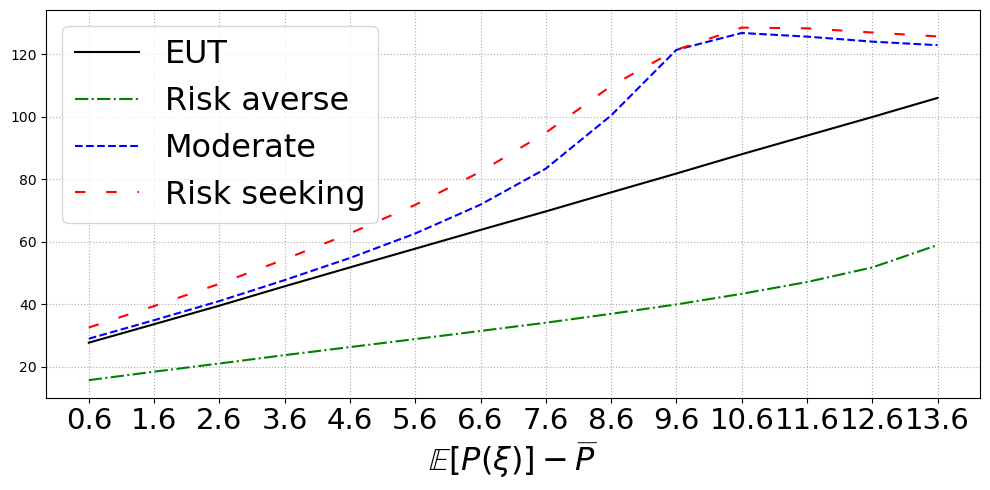

In [32]:
aggregative_game(a_i=0.5, b_i=120, y_i=35, kappa_1=1, kappa_2=2.5, kappa_3=3.2,
                 beta_v=1, gamma_v=0.5, N=3, xi_values=xi_val, P_bar=15.8, b_val=0.5)

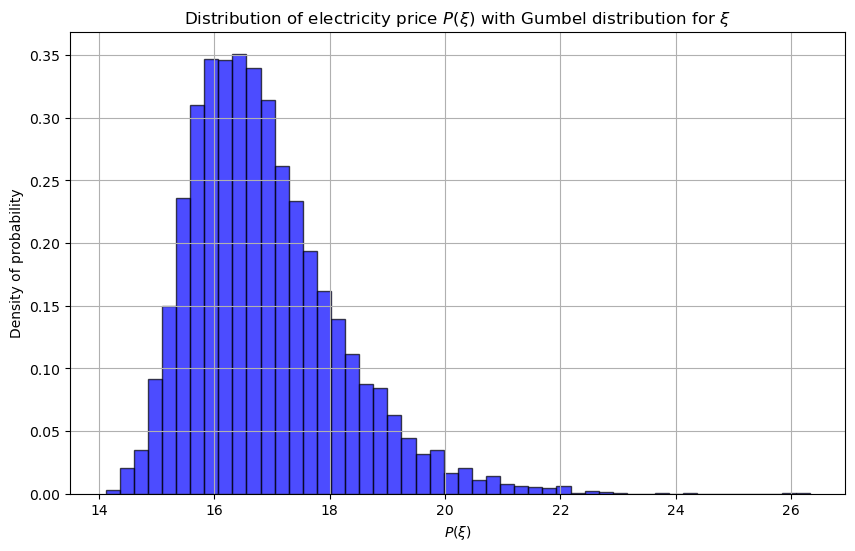

In [33]:
mu, beta = 0, 1 #
#
xi = np.random.gumbel(mu, beta, 10000)
# 
P = 15.8 # 
b = 0.5 # 
P_xi = P + b + xi
# 
plt.figure(figsize=(10, 6))
plt.hist(P_xi, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title(r"Distribution of electricity price $P(\xi)$ with Gumbel distribution for $\xi$")
plt.xlabel(r"$P(\xi)$")
plt.ylabel("Density of probability")
plt.grid(True)
plt.show()